In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import rpy2
import utils
%load_ext rpy2.ipython

## Cancer type specific benchmarks

This is the second attempt at cancer type specific benchmarks. 

### MCF10A benchmark

The first part looks at how well BRCA models predict "activating" vs "neutral" mutations from the Ng et al. study.

In [2]:
# read in the cancer type-specific results
mcf10a_df = pd.read_table('CHASMplus/data/cancer_type_specificity/patrick_et_al_results.txt')
mcf10a_df['Protein_position'] = mcf10a_df['HGVSp_Short'].str.extract('^p\.[A-Z]([0-9]+)[A-Z]$').astype(str)

# read in the pan-cancer predictions
pancan_df = pd.read_table('CHASMplus/data/benchmark/patrick_et_al_results.txt')

mcf10a_df.head()

,ID,Hugo_Symbol,HGVSp_Short,MCF10A functional annotation,gwCHASMplus,CHASM,CanDrA,Protein_position
0,0,AKT1,p.E17K,activating,0.879,0.426,0.564600,17
1,1,AKT1,p.N53H,inactivating,0.478,0.442,0.633400,53
2,2,AKT1,p.R121W,neutral,0.259,0.330,0.286200,121
3,3,AKT3,p.M339I,non-info,0.076,0.756,0.013351,339
4,4,AKT3,p.S370P,non-info,0.080,0.888,-0.043925,370


Merge breast cancer genes identified by the Cancer Gene Census (CGC) and The Cancer Genome Atlas (TCGA).

In [3]:
# read in cgc
cgc_df = utils.process_cgc('CHASMplus/data/misc/Census_allSat Jan  7 18-57-49 2017.tsv', return_dataframe=True)

# Get the BRCA genes from CGC
is_breast = cgc_df['Tumour Types(Somatic)'].str.lower().str.contains('breast')
cgc_brca_genes = cgc_df.loc[is_breast, 'Gene Symbol'].tolist()

# list of BRCA genes from "Comprehensive molecular portraits of human breast tumours", 2012
tcga_brca_genes = [
    'TP53', 'PIK3CA', 'GATA3', 'MAP3K1', 'KMT2C',
    'CDH1', 'MAP2K4', 'RUNX1', 'PTEN', 'TBX3',
    'PIK3R1', 'AKT1', 'CBFB', 'TBL1XR1', 'NCOR1',
    'CTCF', 'ZFP36L1', 'GPS2', 'SF3B1', 'CDKN1B',
    'USH2A', 'RPGR', 'RB1', 'AFF2', 'NF1',
    'PTPN22', 'RYR2', 'PTPRD', 'OR6A2', 'HIST1H2BC',
    'GPR32', 'CLEC19A', 'CCND3', 'SEPT13', 'DCAF4L2'
]

# combine the list together
brca_genes = list(set(cgc_brca_genes) | set(tcga_brca_genes))

Plot the Receivor operating characteristics curve.

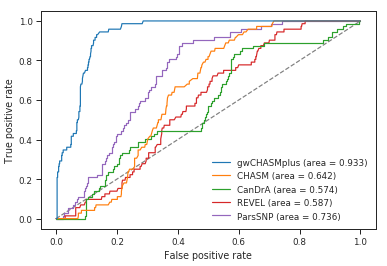

In [4]:
# keep only activating or neutral mutations
is_activating_or_neutral = mcf10a_df['MCF10A functional annotation'].isin(['activating', 'neutral'])
plot_df = mcf10a_df.loc[is_activating_or_neutral, :].copy()

# label brca-specific activating mutations
plot_df['y'] = 0
is_activating = plot_df['MCF10A functional annotation']=='activating'
is_brca = mcf10a_df['Hugo_Symbol'].isin(brca_genes)
plot_df.loc[is_activating & is_brca, 'y'] = 1
plot_df = plot_df.rename(columns={'gwCHASMplus (BRCA)': 'gwCHASMplus', 
                                  'CHASM (BRCA)': 'CHASM', 
                                  'CanDrA (BRCA)': 'CanDrA'})

# merge with pancan predictions
plot_df = pd.merge(plot_df, pancan_df[['Hugo_Symbol', 'HGVSp_Short', 'ParsSNP', 'REVEL']],
                   on=['Hugo_Symbol', 'HGVSp_Short'], how='left')

with sns.axes_style('white'), sns.plotting_context('paper'):
    ax = utils.roc_plot(plot_df, ['gwCHASMplus', 'CHASM', 'CanDrA', 'REVEL', 'ParsSNP'], [])
    plt.plot([0,1], [0, 1],color='gray', ls='--', zorder=-5)
    plt.legend(loc='best', frameon=False)
    plt.savefig('CHASMplus/figures/figure_2a.pdf')

mycols = ['ID', 'Hugo_Symbol', 'HGVSp_Short', 'gwCHASMplus', 'CHASM', 'CanDrA', 'ParsSNP', 'REVEL', 'y']
#plot_df[mycols].to_csv('CHASMplus/data/cancer_type_specificity/patrick_et_al_results_merged.txt', sep='\t', index=False)

### Cancer type-specific MSK impact benchmark based on the cgc

First, read in the tumor sample information from MSK-IMPACT.

In [5]:
# read in sample info
sample_info = pd.read_table('CHASMplus/data/cancer_type_specificity/msk_impact_sample_info.txt')

# keep only the relevant cancer types
ctype_list = ['Breast Invasive Ductal Carcinoma', 'Glioblastoma Multiforme', 
              'Colon Adenocarcinoma', 
              'High-Grade Serous Ovarian Cancer'
             ]
sample_info = sample_info[sample_info['DetailedTumorType'].isin(ctype_list)]

# make label consistent with TCGA
sample_info['CODE'] = 'BRCA'
sample_info.loc[sample_info['DetailedTumorType']==ctype_list[1], 'CODE'] = 'GBM'
sample_info.loc[sample_info['DetailedTumorType']==ctype_list[2], 'CODE'] = 'COAD'
sample_info.loc[sample_info['DetailedTumorType']==ctype_list[3], 'CODE'] = 'OV'

Process the mutations from MSK-IMPACT

In [6]:
# Read in mutation data
useful_cols = ['Hugo_Symbol', 'HGVSp_Short', 'Protein_position', 'Variant_Classification',
               'Tumor_Sample_Barcode', 'CODE']
mut_df = pd.read_table('CHASMplus/data/cancer_type_specificity/original_msk_impact.maf')
# remove duplicate samples
mut_df = mut_df[mut_df.Tumor_Sample_Barcode.str.contains('T01')].copy()

# merge cancer type info
mut_df = pd.merge(mut_df, sample_info[['Assay_ID', 'CODE']],
                  left_on='Tumor_Sample_Barcode', right_on='Assay_ID',
                  how='left')

# Remove duplicate mutations
is_missense = mut_df['Variant_Classification']=='Missense_Mutation'
mut_df['Protein_position'] = mut_df['HGVSp_Short'].str.extract('^p\.[A-Z]([0-9]+)[A-Z]$')
mut_cts = mut_df[is_missense].groupby(['CODE', 'Hugo_Symbol', 'Protein_position']).size().reset_index(name='recurrence')
tmp_mut_df = mut_df[is_missense].drop_duplicates(['CODE', 'Hugo_Symbol', 'HGVSp_Short'])

# merge the codon-level counts with mutations
mut_cts = pd.merge(tmp_mut_df[['CODE', 'Hugo_Symbol', 'Protein_position', 'HGVSp_Short', 'class']], mut_cts,
                   on=['CODE', 'Hugo_Symbol', 'Protein_position'], how='left')

Read in the scores for the different methods and merge them into benchmark.

In [7]:
def rename_col(columns, ctype):
    mymethods = ['gwCHASMplus', 'CHASM', 'CanDrA']
    output_list = []
    for x in columns:
        if x in mymethods:
            x += ' ({0})'.format(ctype)
        output_list.append(x)
    return output_list

# read in scores for various cancer types
brca_df = pd.read_table('CHASMplus/data/cancer_type_specificity/msk_impact_results_brca.txt')
brca_df.columns = rename_col(brca_df.columns, 'BRCA')
coad_df = pd.read_table('CHASMplus/data/cancer_type_specificity/msk_impact_results_coad.txt')
coad_df.columns = rename_col(coad_df.columns, 'COAD')
gbm_df = pd.read_table('CHASMplus/data/cancer_type_specificity/msk_impact_results_gbm.txt')
gbm_df.columns = rename_col(gbm_df.columns, 'GBM')
ov_df = pd.read_table('CHASMplus/data/cancer_type_specificity/msk_impact_results_ov.txt')
ov_df.columns = rename_col(ov_df.columns, 'OV')
score_dict = {'BRCA': brca_df, 'COAD': coad_df, 'GBM': gbm_df, 'OV': ov_df}

# read in scores for "pan-cancer" predictions
pancan_df = pd.read_table('CHASMplus/data/benchmark/msk_impact_results.txt')

# Create a dataframe that contains the benchmark info
benchmark_df = mut_cts.copy()
# merge in score information for cancer types
benchmark_df = pd.merge(benchmark_df, brca_df, on=['Hugo_Symbol', 'HGVSp_Short'], how='left')
benchmark_df = pd.merge(benchmark_df, coad_df, on=['Hugo_Symbol', 'HGVSp_Short'], how='left')
benchmark_df = pd.merge(benchmark_df, gbm_df, on=['Hugo_Symbol', 'HGVSp_Short'], how='left')
benchmark_df = pd.merge(benchmark_df, ov_df, on=['Hugo_Symbol', 'HGVSp_Short'], how='left')
# merge in the pancan scores
benchmark_df = pd.merge(benchmark_df, pancan_df[['Hugo_Symbol', 'HGVSp_Short', 'ParsSNP', 'REVEL']],
                        on=['Hugo_Symbol', 'HGVSp_Short'], how='left')

Establish a list of genes relevant for each cancer type.

In [8]:
# figure out the cancer type relevant genes
# Get the BRCA genes from CGC
cgc_brca_genes = cgc_df.loc[cgc_df['Tumour Types(Somatic)'].str.contains('breast'), 'Gene Symbol'].tolist()
# list of BRCA genes from "Comprehensive molecular portraits of human breast tumours", 2012
tcga_brca_genes = [
    'TP53', 'PIK3CA', 'GATA3', 'MAP3K1', 'KMT2C',
    'CDH1', 'MAP2K4', 'RUNX1', 'PTEN', 'TBX3',
    'PIK3R1', 'AKT1', 'CBFB', 'TBL1XR1', 'NCOR1',
    'CTCF', 'ZFP36L1', 'GPS2', 'SF3B1', 'CDKN1B',
    'USH2A', 'RPGR', 'RB1', 'AFF2', 'NF1',
    'PTPN22', 'RYR2', 'PTPRD', 'OR6A2', 'HIST1H2BC',
    'GPR32', 'CLEC19A', 'CCND3', 'SEPT13', 'DCAF4L2'
]
# combine the list together
brca_genes = list(set(cgc_brca_genes) | set(tcga_brca_genes))


# Get the GBM genes from CGC, based on "glioma"
cgc_gbm_genes = cgc_df.loc[cgc_df['Tumour Types(Somatic)'].str.lower().str.contains('\\bglioma\\b|gliblastoma'), 'Gene Symbol'].tolist()
# GBM genes identified as significant by INVEX in "The Somatic Genomic Landscape of Glioblastoma"
tcga_gbm_genes = [
 'TP53', 'EGFR', 'PTEN', 'NF1', 'PIK3CA',
 'PIK3R1', 'RB1', 'IDH1', 'PDGFRA', 'LZTR1'
]
# combine the list together
gbm_genes = list(set(cgc_gbm_genes) | set(tcga_gbm_genes))

# Get the colon genes from CGC, based on "colon" or "colorectal"
cgc_coad_genes = cgc_df.loc[cgc_df['Tumour Types(Somatic)'].str.lower().str.contains('colorectal|colon'), 'Gene Symbol'].tolist()
# identified as significant in "Comprehensive molecular characterization of human colon and rectal cancer"
# this list was identified by mutsig and manual curation
tcga_coad_genes = [
    'ACVR1B', 'ACVR2A', 'APC', 'BRAF', 'CASP8',
    'CDC27', 'CTNNB1', 'EDNRB', 'FAM123B', 'FBXW7',
    'FZD3', 'GPC6', 'KIAA1804', 'KRAS', 'MAP7',
    'MIER3', 'MSH3', 'MSH6', 'MYO1B', 'NRAS',
    'PIK3CA', 'PTPN12', 'SMAD2', 'SMAD4', 'SOX9',
    'TCERG1', 'TCF7L2', 'TGFBR2', 'TP53', 'TTN'
]
# combine the list together
coad_genes = list(set(cgc_coad_genes) | set(tcga_coad_genes))

# Get the ovarian genes from CGC, based on "ovarian"
is_ovarian = cgc_df['Tumour Types(Somatic)'].str.lower().str.contains('ovarian')
is_not_clear_cell_ovarian = ~cgc_df['Tumour Types(Somatic)'].str.lower().str.contains('clear cell ovarian')
cgc_ov_genes = cgc_df.loc[is_ovarian & is_not_clear_cell_ovarian, 'Gene Symbol'].tolist()
# identified as significant by "Integrated genomic analyses of ovarian carcinoma"
tcga_ov_genes = [
    'TP53', 'BRCA1', 'CSMD3', 'NF1', 'CDK12', 
    'FAT3', 'GABRA6', 'BRCA2', 'RB1'
]
# combine the list together
ov_genes = list(set(cgc_ov_genes) | set(tcga_ov_genes))

# dictionary of genes
driver_genes = {
    'BRCA': brca_genes,
    'COAD': coad_genes,
    'GBM': gbm_genes,
    'OV': ov_genes
}

Plot the ROC curve

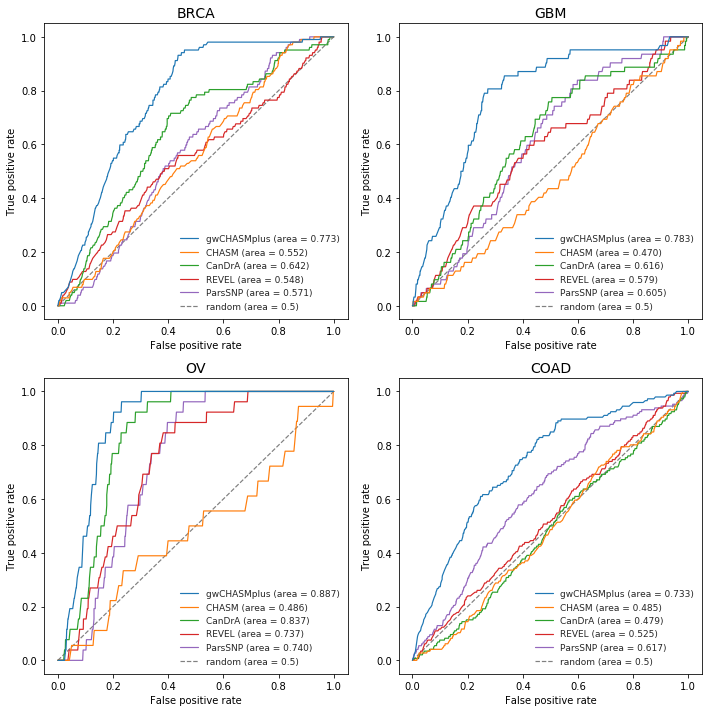

In [9]:
ctype_list = ['BRCA', 'GBM', 'OV', 'COAD']

fig, axes = plt.subplots(2, 2, sharey=True, sharex=True)
axes = axes.flatten()
fig.set_size_inches(10, 10)
for i, cancer_type in enumerate(ctype_list):
    plt.sca(axes[i])
    
    # label the cancer type-specific "oncogenic" mutations
    is_oncogenic = benchmark_df['class'].isin(['Oncogenic', 'Likely Oncogenic'])
    benchmark_df['y'] = 0
    benchmark_df.loc[(is_oncogenic) & (benchmark_df['Hugo_Symbol'].isin(driver_genes[cancer_type])) & (benchmark_df['CODE']==cancer_type), 'y'] = 1

    # roc plot
    plot_df = benchmark_df[is_oncogenic].copy()
    plot_df.columns = [c[:-(len(cancer_type)+3)] if c.endswith(' ({0})'.format(cancer_type)) else c 
                       for c in plot_df.columns]
    with sns.axes_style('white'), sns.plotting_context('paper', font_scale=2):
        # plotting
        utils.roc_plot(plot_df,
                       ['gwCHASMplus',  
                        'CHASM', 
                        'CanDrA',
                        'REVEL',
                        'ParsSNP'],
                       [])
        plt.plot([0,1], [0, 1],color='gray', ls='--', zorder=-5, label='random (area = 0.5)')
        plt.legend(loc='best', frameon=False, fontsize=9)
        plt.title(cancer_type, size=14)
    
    # save dataframe
    mycols = ['CODE', 'Hugo_Symbol', 'HGVSp_Short', 'gwCHASMplus', 'CHASM', 'CanDrA', 'ParsSNP', 'REVEL', 'y']
    #plot_df[mycols].to_csv('CHASMplus/data/cancer_type_specificity/msk_impact_results_{0}_merged.txt'.format(cancer_type), sep='\t', index=False)

plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_2b.pdf')

### EGFR example

EGFR driver mutations are known to be located differently in glioblastoma multiforme as compared to lung adenocarcinoma. Specifically, EGFR extracellular domain mutations are common in glioblastoma multiforme, while kinase domain mutations are common in lung adenocarcinoma.

In [10]:
# read in the score information for EGFR mutations from the TCGA
egfr_df = pd.read_table('CHASMplus/data/cancer_type_specificity/egfr_gbm_luad.txt')

# label the extracellular vs intracellular
egfr_df['domain'] = 'cytoplasmic'
egfr_df.loc[egfr_df['Protein_position']<=645, 'domain'] = 'extracellular'
mycols = ['gwCHASMplus (GBM)', 'gwCHASMplus (LUAD)', 'CHASM (GBM)', 
          'CHASM (LUAD)', 'CanDrA (GBM)', 'REVEL', 'ParsSNP', 'CODE',]
tmp_df = egfr_df.sort_values('Protein_position')[mycols].copy()
plot_df = pd.melt(tmp_df, id_vars=['CODE', 'domain'], 
                  value_vars=['gwCHASMplus (GBM)', 'gwCHASMplus (LUAD)', 'CHASM (GBM)', 
                              'CHASM (LUAD)', 'CanDrA (GBM)', 'REVEL', 'ParsSNP'],
                  var_name='method', value_name='score')

Plot the lung adenocarcinoma and glioblastoma multiforme scores for EGFR.

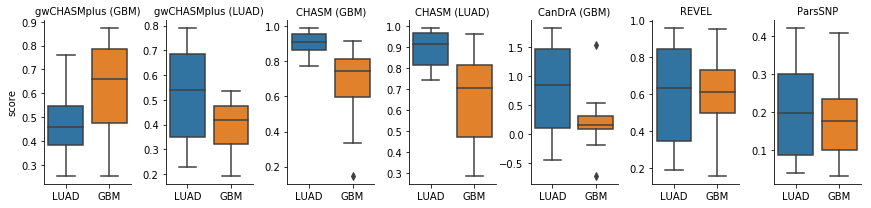

In [11]:
cur_pal = sns.color_palette()
g = sns.FacetGrid(plot_df, col="method", margin_titles=True, sharey=False, aspect=.75, col_wrap=7)
g.map(sns.boxplot, 'CODE', "score", order=['LUAD', 'GBM'], palette=[cur_pal[0], cur_pal[1]])
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xlabels('')
plt.tight_layout()
plt.gcf().set_size_inches(12, 3)
plt.savefig('CHASMplus/figures/figure_2c.pdf')

#### Statistical test

In [12]:
# whether the mutation comes from lung adenocarcinoma or glioblastoma multiforme
is_luad = plot_df['CODE']=='LUAD'
is_gbm = plot_df['CODE']=='GBM'

# different methods
chasmplus_gbm = 'gwCHASMplus (GBM)'
chasmplus_luad = 'gwCHASMplus (LUAD)'
chasm_gbm = 'CHASM (GBM)'
chasm_luad = 'CHASM (LUAD)'
candra_gbm = 'CanDrA (GBM)'
revel = 'REVEL'
parssnp = 'ParsSNP'

# perform ttests
print('Two-sided T test:')
print('-'*17)
t, pval = stats.ttest_ind(plot_df[is_luad & (plot_df['method']==chasmplus_gbm)]['score'],
                          plot_df[is_gbm & (plot_df['method']==chasmplus_gbm)]['score'])
print('{0} : n={1}, p={2:.3g}'.format(chasmplus_gbm, len(plot_df[plot_df['method']==chasmplus_gbm]), pval))
t, pval = stats.ttest_ind(plot_df[is_luad & (plot_df['method']==chasmplus_luad)]['score'],
                          plot_df[is_gbm & (plot_df['method']==chasmplus_luad)]['score'])
print('{0}: n={1}, p={2:.3g}'.format(chasmplus_luad, len(plot_df[plot_df['method']==chasmplus_luad]),  pval))
t, pval = stats.ttest_ind(plot_df[is_luad & (plot_df['method']==chasm_gbm)]['score'],
                          plot_df[is_gbm & (plot_df['method']==chasm_gbm)]['score'])
print('{0}: n={1}, p={2:.3g}'.format(chasm_gbm, len(plot_df[plot_df['method']==chasm_gbm]), pval))
t, pval = stats.ttest_ind(plot_df[is_luad & (plot_df['method']==chasm_luad)]['score'],
                          plot_df[is_gbm & (plot_df['method']==chasm_luad)]['score'])
print('{0}: n={1}, p={2:.3g}'.format(chasm_luad, len(plot_df[plot_df['method']==chasm_luad]), pval))
t, pval = stats.ttest_ind(plot_df[is_luad & (plot_df['method']==candra_gbm)]['score'],
                          plot_df[is_gbm & (plot_df['method']==candra_gbm)]['score'])
print('{0}: n={1}, p={2:.3g}'.format(candra_gbm, len(plot_df[plot_df['method']==candra_gbm]), pval))
t, pval = stats.ttest_ind(plot_df[is_luad & (plot_df['method']==revel)]['score'],
                          plot_df[is_gbm & (plot_df['method']==revel)]['score'])
print('{0}: n={1}, p={2:.3g}'.format(revel, len(plot_df[plot_df['method']==revel]), pval))
t, pval = stats.ttest_ind(plot_df[is_luad & (plot_df['method']==parssnp)]['score'],
                          plot_df[is_gbm & (plot_df['method']==parssnp)]['score'])
print('{0}: n={1}, p={2:.3g}'.format(parssnp, len(plot_df[plot_df['method']==parssnp]), pval))

Two-sided T test:
-----------------
gwCHASMplus (GBM) : n=52, p=0.00376
gwCHASMplus (LUAD): n=52, p=0.00272
CHASM (GBM): n=52, p=1.17e-05
CHASM (LUAD): n=52, p=4.59e-05
CanDrA (GBM): n=52, p=0.000215
REVEL: n=52, p=0.998
ParsSNP: n=52, p=0.527
